# BLIP-2 Explorer — LoRA Fine-Tuning on the Underwater Image Captioning Dataset (UICD)

**Model:** [Salesforce/blip2-opt-2.7b](https://huggingface.co/Salesforce/blip2-opt-2.7b)  
**Dataset:** [kevintang2048/underwater-image-captioning-dataset-uicd](https://www.kaggle.com/datasets/kevintang2048/underwater-image-captioning-dataset-uicd)  
**Accelerator:** Kaggle Notebooks — T4 x2

---

## Abstract

The application of large language models to image-to-text tasks in offline settings is often constrained by limited hardware resources, with deployment bottlenecks arising in embedded environments where high-accuracy models are too large for local operation. This limitation is particularly evident in marine imaging systems for ecological research, where real-time image captioning can enhance the utility of video footage by maintaining a searchable text-based record, yet has to operate entirely on-device in underwater environments with limited or unreliable internet connectivity. To address this challenge, we introduce **BLIP-2 Explorer**, a lightweight image captioning model based on BLIP-2 that is specialised for marine image captioning through domain-specific fine-tuning. In developing BLIP-2 Explorer, we combine knowledge distillation with low-rank adaptation (LoRA)-based parameter-efficient fine-tuning to substantially reduce the size of the original BLIP-2 architecture while preserving comparable image captioning performance in marine-specific contexts.

---

## Notebook Structure

| # | Section |
|---|---------|
| 1 | Environment Setup |
| 2 | GPU / Memory Check |
| 3 | Configuration |
| 4 | Dataset Loading |
| 5 | Train / Val / Test Split |
| 6 | PyTorch Dataset & DataLoaders |
| 7 | Load Base Model & Processor |
| 8 | Apply LoRA (PEFT) |
| 9 | Optimizer & Scheduler |
| 10 | Training Loop |
| 11 | Loss Visualisation |
| 12 | Generate Test Captions |
| 13 | COCO Evaluation Metrics |
| 14 | Save Outputs |

## 1 · Environment Setup

In [1]:
# ── Install packages not pre-installed in Kaggle Notebooks ──────────────────
import subprocess, sys

subprocess.run([
    sys.executable, "-m", "pip", "install", "-q",
    "peft>=0.5.0",
    "pycocoevalcap",
    "pycocotools",
    "open_clip_torch",
], check=True)

# ── Standard library ─────────────────────────────────────────────────────────
import gc
import json
import os
import random
import time
from pathlib import Path

# ── Third-party ───────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# ── HuggingFace ───────────────────────────────────────────────────────────────
from transformers import (
    AutoProcessor,
    Blip2ForConditionalGeneration,
    get_linear_schedule_with_warmup,
)

# ── PEFT / LoRA ───────────────────────────────────────────────────────────────
from peft import LoraConfig, get_peft_model, TaskType

print("All imports successful.")

All imports successful.


## 2 · GPU / Memory Check

In [2]:
gc.collect()
torch.cuda.empty_cache()

if not torch.cuda.is_available():
    raise EnvironmentError("No CUDA device found — enable the T4 x2 accelerator in Kaggle settings.")

device = torch.device("cuda")
n_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {n_gpus}")
for i in range(n_gpus):
    props = torch.cuda.get_device_properties(i)
    total_vram = props.total_memory / 1024**3
    free_vram  = (props.total_memory - torch.cuda.memory_allocated(i)) / 1024**3
    print(f"  GPU {i}: {props.name}  |  Total VRAM: {total_vram:.1f} GB  |  Free VRAM: {free_vram:.1f} GB")

Number of GPUs: 2
  GPU 0: Tesla T4  |  Total VRAM: 14.6 GB  |  Free VRAM: 14.6 GB
  GPU 1: Tesla T4  |  Total VRAM: 14.6 GB  |  Free VRAM: 14.6 GB


## 3 · Configuration

In [3]:
CONFIG = {
    # ── Model ────────────────────────────────────────────────────────────────
    "model_id": "Salesforce/blip2-opt-2.7b",

    # ── Dataset ──────────────────────────────────────────────────────────────
    "dataset_root": "/kaggle/input/datasets/kevintang2048/underwater-image-captioning-dataset-uicd",
    "split": (0.8, 0.1, 0.1),   # train / val / test fractions
    "seed": 42,

    # ── Training ─────────────────────────────────────────────────────────────
    "epochs": 5,
    "batch_size": 3,
    "lr": 2e-4,
    "max_length": 256,           # tokenizer max sequence length
    "warmup_ratio": 0.1,         # fraction of total steps used for lr warmup

    # ── LoRA ─────────────────────────────────────────────────────────────────
    "lora_r": 16,
    "lora_alpha": 16,
    "lora_dropout": 0.1,
    "lora_bias": "none",          # "all" trains every model bias → fp16 overflow
    "lora_target_modules": ["q_proj", "k_proj"],

    # ── Output ───────────────────────────────────────────────────────────────
    "output_dir": "/kaggle/working/blip2_lora_uicd",
}

# Create output directory
Path(CONFIG["output_dir"]).mkdir(parents=True, exist_ok=True)

# Deterministic seeding
random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["seed"])

print("CONFIG:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

CONFIG:
  model_id: Salesforce/blip2-opt-2.7b
  dataset_root: /kaggle/input/datasets/kevintang2048/underwater-image-captioning-dataset-uicd
  split: (0.8, 0.1, 0.1)
  seed: 42
  epochs: 5
  batch_size: 3
  lr: 0.0002
  max_length: 256
  warmup_ratio: 0.1
  lora_r: 16
  lora_alpha: 16
  lora_dropout: 0.1
  lora_bias: none
  lora_target_modules: ['q_proj', 'k_proj']
  output_dir: /kaggle/working/blip2_lora_uicd


## 4 · Dataset Loading

Parses `UIC-captions.txt` (format: `<image_id>#<caption_index> <caption_text>`) and pairs each image filename with its list of reference captions.

In [4]:
def load_captions(captions_path: Path) -> dict:
    """Parse UIC-captions.txt into {filename: [caption, ...]}."""
    captions_dict = {}
    with open(captions_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Format: <img_id>#<n> <caption text>
            parts = line.split(" ", 1)
            if len(parts) != 2:
                continue
            img_key, caption = parts
            filename = img_key.split("#")[0]
            captions_dict.setdefault(filename, []).append(caption.strip())
    return captions_dict


dataset_root = Path(CONFIG["dataset_root"])

# Locate captions file and image directory
captions_file = next(dataset_root.rglob("UIC-captions.txt"), None)
if captions_file is None:
    raise FileNotFoundError(f"UIC-captions.txt not found under {dataset_root}")

dataset_base = captions_file.parent
image_dir    = dataset_base / "uic_224x224_image"
if not image_dir.exists():
    # Fallback: look for any image-containing subdirectory
    image_dirs = [d for d in dataset_base.iterdir() if d.is_dir()]
    if not image_dirs:
        raise FileNotFoundError(f"No image directory found under {dataset_base}")
    image_dir = image_dirs[0]

captions_dict = load_captions(captions_file)

# Build flat dataset list
dataset = []
for filename, captions in captions_dict.items():
    img_path = image_dir / filename
    if img_path.exists():
        dataset.append({
            "image_path":     str(img_path),
            "image_filename": filename,
            "captions":       captions,
        })

print(f"Captions file : {captions_file}")
print(f"Image directory: {image_dir}")
print(f"Total samples  : {len(dataset)}")
print(f"Sample entry   : {dataset[0]}")

Captions file : /kaggle/input/datasets/kevintang2048/underwater-image-captioning-dataset-uicd/UIC(underwater image captioning dataset)/UIC-captions.txt
Image directory: /kaggle/input/datasets/kevintang2048/underwater-image-captioning-dataset-uicd/UIC(underwater image captioning dataset)/uic_224x224_image
Total samples  : 3176
Sample entry   : {'image_path': '/kaggle/input/datasets/kevintang2048/underwater-image-captioning-dataset-uicd/UIC(underwater image captioning dataset)/uic_224x224_image/uic_img_1.jpg', 'image_filename': 'uic_img_1.jpg', 'captions': ['A dark brown turtle paddles through the water with its limbs .', 'A brown sea turtle paddles its limbs and swims in the clear water .', 'A close-up of a brown turtle swims in the sea .', 'There is a sea turtle swimming in the water .', 'A sea turtle swims in clear water .']}


## 5 · Train / Val / Test Split

In [5]:
train_frac, val_frac, test_frac = CONFIG["split"]

dataset_sorted = sorted(dataset, key=lambda x: x["image_filename"])
rng = random.Random(CONFIG["seed"])
rng.shuffle(dataset_sorted)

n = len(dataset_sorted)
n_train = int(n * train_frac)
n_val   = int(n * val_frac)

train_set = dataset_sorted[:n_train]
val_set   = dataset_sorted[n_train : n_train + n_val]
test_set  = dataset_sorted[n_train + n_val :]

print(f"Total : {n}")
print(f"Train : {len(train_set)}  ({len(train_set)/n*100:.1f}%)")
print(f"Val   : {len(val_set)}   ({len(val_set)/n*100:.1f}%)")
print(f"Test  : {len(test_set)}  ({len(test_set)/n*100:.1f}%)")

Total : 3176
Train : 2540  (80.0%)
Val   : 317   (10.0%)
Test  : 319  (10.0%)


## 6 · PyTorch Dataset & DataLoaders

`UICDataset` randomly selects one reference caption per image per training step, feeds it through the BLIP-2 processor, and masks padding tokens in `labels` to -100 so they are excluded from the cross-entropy loss.

In [6]:
class UICDataset(Dataset):
    """PyTorch Dataset for the Underwater Image Captioning Dataset."""

    def __init__(self, samples: list, processor, max_length: int = 256):
        self.samples    = samples
        self.processor  = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]

        # Load image
        image = Image.open(item["image_path"]).convert("RGB")

        # Randomly pick one reference caption for this step
        caption = random.choice(item["captions"])

        # Tokenise
        encoding = self.processor(
            images=image,
            text=caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
        )

        # Remove batch dimension added by processor
        pixel_values = encoding["pixel_values"].squeeze(0)       # (C, H, W)
        input_ids    = encoding["input_ids"].squeeze(0)           # (L,)
        attention_mask = encoding["attention_mask"].squeeze(0)    # (L,)

        # Labels: copy of input_ids with padding replaced by -100
        labels = input_ids.clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values":  pixel_values,
            "input_ids":     input_ids,
            "attention_mask": attention_mask,
            "labels":        labels,
        }


# DataLoaders are created after the processor is loaded (next section).
# They are defined here so the class is available for inspection.
print("UICDataset class defined.")

UICDataset class defined.


## 7 · Load Base Model & Processor

Loads `Salesforce/blip2-opt-2.7b` in **fp16** with `device_map="auto"` — Accelerate automatically pipelines the model across both T4 GPUs. All base parameters are frozen; only the LoRA adapters (added in the next section) will be trainable.

In [7]:
import warnings
# Suppress harmless accelerate warning about query_tokens (nn.Parameter, not a submodule)
warnings.filterwarnings("ignore", message=".*query_tokens.*")

gc.collect()
torch.cuda.empty_cache()

model_id = CONFIG["model_id"]

# ── Processor ─────────────────────────────────────────────────────────────────
print("Loading processor...")
processor = AutoProcessor.from_pretrained(model_id)
processor.tokenizer.model_max_length = CONFIG["max_length"]

# ── Base model in fp16 — device_map="auto" splits across both T4s ─────────────
print("Loading base model (fp16)...")
model = Blip2ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
)

# Freeze all base parameters
for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
print(f"\nBase model loaded. Total parameters: {total_params / 1e9:.2f} B")
print(f"Device map: {model.hf_device_map if hasattr(model, 'hf_device_map') else 'single device'}")


def _fix_language_model_device_map(m) -> None:
    """Ensure hf_device_map contains a 'language_model' entry.

    When BLIP-2 is loaded with device_map='auto', Accelerate maps individual
    sub-layers (e.g. 'language_model.model.decoder.layers.0') but omits the
    top-level 'language_model' key.  BLIP-2's generate() checks for that key
    and emits a spurious multi-GPU warning when it is absent.  We infer the
    correct device from the first parameter of language_model and add the entry.
    """
    base = getattr(m, "base_model", m)   # unwrap PEFT wrapper if present
    hf_map = getattr(base, "hf_device_map", None)
    if hf_map is None or "language_model" in hf_map:
        return
    lm = getattr(base, "language_model", None)
    if lm is None:
        return
    try:
        lm_device = next(lm.parameters()).device
        hf_map["language_model"] = lm_device.index if lm_device.type == "cuda" else lm_device
        print(f"hf_device_map patched: language_model → GPU {hf_map['language_model']}")
    except StopIteration:
        pass


_fix_language_model_device_map(model)

# ── Build DataLoaders now that the processor is available ─────────────────────
# num_workers=0 avoids multiprocessing AssertionError in Kaggle/Jupyter notebooks
train_dataset = UICDataset(train_set, processor, CONFIG["max_length"])
val_dataset   = UICDataset(val_set,   processor, CONFIG["max_length"])
test_dataset  = UICDataset(test_set,  processor, CONFIG["max_length"])

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=1,                    shuffle=False, num_workers=0, pin_memory=True)

print(f"\nTrain batches : {len(train_loader)}")
print(f"Val batches   : {len(val_loader)}")
print(f"Test batches  : {len(test_loader)}")


Loading processor...


The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading base model (fp16)...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/1247 [00:00<?, ?it/s]


Base model loaded. Total parameters: 3.74 B
Device map: {'query_tokens': 0, 'vision_model': 0, 'qformer': 0, 'language_projection': 0, 'language_model.model.decoder.embed_tokens': 0, 'language_model.lm_head': 0, 'language_model.model.decoder.embed_positions': 0, 'language_model.model.decoder.final_layer_norm': 0, 'language_model.model.decoder.layers.0': 0, 'language_model.model.decoder.layers.1': 0, 'language_model.model.decoder.layers.2': 0, 'language_model.model.decoder.layers.3': 0, 'language_model.model.decoder.layers.4': 0, 'language_model.model.decoder.layers.5': 0, 'language_model.model.decoder.layers.6': 0, 'language_model.model.decoder.layers.7': 0, 'language_model.model.decoder.layers.8': 1, 'language_model.model.decoder.layers.9': 1, 'language_model.model.decoder.layers.10': 1, 'language_model.model.decoder.layers.11': 1, 'language_model.model.decoder.layers.12': 1, 'language_model.model.decoder.layers.13': 1, 'language_model.model.decoder.layers.14': 1, 'language_model.mod

## 8 · Apply LoRA (PEFT)

Injects low-rank adapter matrices into the `q_proj` and `k_proj` layers of both the Q-Former cross-attention blocks and the OPT decoder — matching the "query and key layers" specification from the reference methodology. Only these adapter weights (~0.77% of total parameters) will be updated during training.

In [8]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=CONFIG["lora_r"],
    lora_alpha=CONFIG["lora_alpha"],
    lora_dropout=CONFIG["lora_dropout"],
    bias=CONFIG["lora_bias"],
    target_modules=CONFIG["lora_target_modules"],
)

model = get_peft_model(model, lora_config)

# Re-apply the device-map patch: get_peft_model() wraps the model in a new
# PeftModel object whose hf_device_map may again be missing 'language_model'.
_fix_language_model_device_map(model)

# ── Trainable parameter report ────────────────────────────────────────────────
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params        = sum(p.numel() for p in model.parameters())
pct               = 100 * trainable_params / all_params

print(f"Trainable parameters : {trainable_params:,}  ({pct:.2f}% of total)")
print(f"Total parameters     : {all_params:,}")
model.print_trainable_parameters()


Trainable parameters : 5,242,880  (0.14% of total)
Total parameters     : 3,750,004,736
trainable params: 5,242,880 || all params: 3,750,004,736 || trainable%: 0.1398


## 9 · Optimizer & Scheduler

In [9]:
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"],
)

total_training_steps = CONFIG["epochs"] * len(train_loader)
warmup_steps = int(total_training_steps * CONFIG["warmup_ratio"])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps,
)

print(f"Total training steps : {total_training_steps}")
print(f"Warmup steps         : {warmup_steps}")
print(f"Learning rate        : {CONFIG['lr']}")

Total training steps : 4235
Warmup steps         : 423
Learning rate        : 0.0002


## 10 · Training Loop

- Per-step training loss is recorded at every gradient step for fine-grained visualisation.
- Validation loss is computed at the end of each epoch (no generation — keeps epoch runtime manageable on T4 x2).
- The best checkpoint (lowest validation loss) is saved to `output_dir/best_checkpoint/`.

In [10]:
# ── Tracking ──────────────────────────────────────────────────────────────────
step_train_losses = []   # list of (global_step, loss)
epoch_val_losses  = []   # list of val_loss per epoch
epoch_boundaries  = []   # global_step at the end of each epoch
global_step       = 0
best_val_loss     = float("inf")

best_ckpt_dir = Path(CONFIG["output_dir"]) / "best_checkpoint"

# TF32 uses fp32-range exponents in matmuls → avoids the +/-65504 fp16 overflow
# that causes NaN in Q-Former attention from the very first forward pass on T4.
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32       = True

# GradScaler prevents fp16 gradient underflow/overflow that causes NaN losses.
# Use a conservative init_scale (2^14 instead of default 2^16) to reduce early overflow.
scaler = torch.amp.GradScaler("cuda", init_scale=2**14)

model.train()

for epoch in range(1, CONFIG["epochs"] + 1):
    # ── Training ──────────────────────────────────────────────────────────────
    model.train()
    train_loss_sum = 0.0
    train_steps    = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{CONFIG['epochs']} [train]", leave=True)
    for batch in pbar:
        # Move tensors to the first CUDA device; model uses device_map="auto"
        batch = {k: v.to(device) for k, v in batch.items()}
        # Explicitly cast pixel_values to fp16 to match model dtype and prevent
        # implicit dtype promotion that can overflow fp16 range across devices.
        if "pixel_values" in batch:
            batch["pixel_values"] = batch["pixel_values"].to(torch.float16)

        optimizer.zero_grad()

        with torch.amp.autocast("cuda", dtype=torch.float16):
            outputs = model(**batch)
            loss    = outputs.loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        loss_val = loss.item()

        # Guard: skip NaN/inf steps (GradScaler already skips the optimizer step,
        # but we must not accumulate NaN into the running sum)
        if not torch.isfinite(torch.tensor(loss_val)):
            global_step += 1
            pbar.set_postfix({"loss": "NaN – skipped"})
            continue

        train_loss_sum += loss_val
        train_steps    += 1
        step_train_losses.append((global_step, loss_val))
        global_step += 1

        pbar.set_postfix({"loss": f"{loss_val:.4f}"})

    avg_train_loss = train_loss_sum / max(train_steps, 1)
    epoch_boundaries.append(global_step)

    # ── Validation ────────────────────────────────────────────────────────────
    model.eval()
    val_loss_sum = 0.0
    val_steps    = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{CONFIG['epochs']} [val]", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            if "pixel_values" in batch:
                batch["pixel_values"] = batch["pixel_values"].to(torch.float16)
            with torch.amp.autocast("cuda", dtype=torch.float16):
                outputs = model(**batch)
            v_loss = outputs.loss.item()
            if torch.isfinite(torch.tensor(v_loss)):
                val_loss_sum += v_loss
                val_steps    += 1

    avg_val_loss = val_loss_sum / max(val_steps, 1)
    epoch_val_losses.append(avg_val_loss)

    print(f"\nEpoch {epoch}  |  train_loss: {avg_train_loss:.4f}  |  val_loss: {avg_val_loss:.4f}")

    # ── Save best checkpoint ──────────────────────────────────────────────────
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(str(best_ckpt_dir))
        processor.save_pretrained(str(best_ckpt_dir))
        print(f"  ✓ Best checkpoint saved (val_loss={best_val_loss:.4f})")

print("\nTraining complete.")


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


Epoch 1/5 [train]:   0%|          | 0/847 [00:00<?, ?it/s]

Epoch 1/5 [val]:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 1  |  train_loss: 2.5842  |  val_loss: 0.7920
  ✓ Best checkpoint saved (val_loss=0.7920)


Epoch 2/5 [train]:   0%|          | 0/847 [00:00<?, ?it/s]

Epoch 2/5 [val]:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 2  |  train_loss: 0.8493  |  val_loss: 0.7239
  ✓ Best checkpoint saved (val_loss=0.7239)


Epoch 3/5 [train]:   0%|          | 0/847 [00:00<?, ?it/s]

Epoch 3/5 [val]:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 3  |  train_loss: 0.7997  |  val_loss: 0.6988
  ✓ Best checkpoint saved (val_loss=0.6988)


Epoch 4/5 [train]:   0%|          | 0/847 [00:00<?, ?it/s]

Epoch 4/5 [val]:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 4  |  train_loss: 0.7744  |  val_loss: 0.6905
  ✓ Best checkpoint saved (val_loss=0.6905)


Epoch 5/5 [train]:   0%|          | 0/847 [00:00<?, ?it/s]

Epoch 5/5 [val]:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 5  |  train_loss: 0.7582  |  val_loss: 0.6947

Training complete.


## 11 · Loss Visualisation

Loss curves saved to: /kaggle/working/blip2_lora_uicd/loss_curves.png


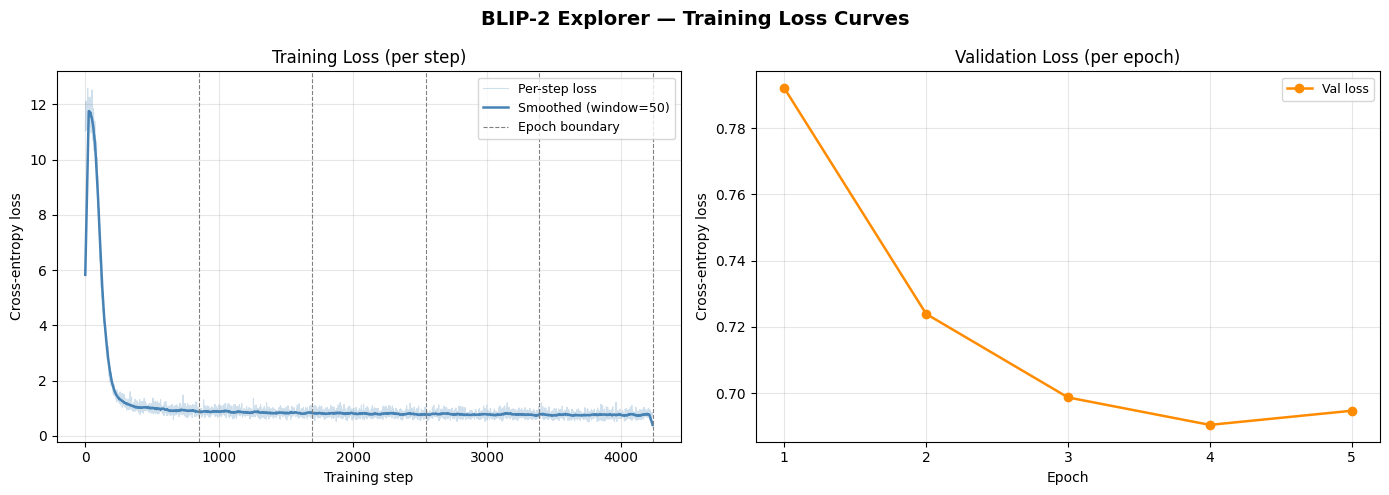

In [11]:
def smooth(values: list, window: int = 50) -> np.ndarray:
    """Simple rolling-mean smoother (same-length output, edge-padded)."""
    arr = np.array(values, dtype=np.float32)
    if len(arr) < window:
        return arr
    kernel = np.ones(window) / window
    return np.convolve(arr, kernel, mode="same")


steps  = [s for s, _ in step_train_losses]
losses = [l for _, l in step_train_losses]
smoothed = smooth(losses)

epochs_x = list(range(1, len(epoch_val_losses) + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("BLIP-2 Explorer — Training Loss Curves", fontsize=14, fontweight="bold")

# ── Left: per-step training loss ──────────────────────────────────────────────
ax1.plot(steps, losses,   color="steelblue", alpha=0.25, linewidth=0.8, label="Per-step loss")
ax1.plot(steps, smoothed, color="steelblue", linewidth=1.8,              label=f"Smoothed (window=50)")

# Epoch boundary markers
for i, boundary in enumerate(epoch_boundaries):
    ax1.axvline(x=boundary, color="gray", linestyle="--", linewidth=0.8,
                label="Epoch boundary" if i == 0 else None)

ax1.set_xlabel("Training step")
ax1.set_ylabel("Cross-entropy loss")
ax1.set_title("Training Loss (per step)")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# ── Right: per-epoch validation loss ─────────────────────────────────────────
ax2.plot(epochs_x, epoch_val_losses, color="darkorange", marker="o",
         linewidth=1.8, markersize=6, label="Val loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Cross-entropy loss")
ax2.set_title("Validation Loss (per epoch)")
ax2.set_xticks(epochs_x)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

loss_plot_path = str(Path(CONFIG["output_dir"]) / "loss_curves.png")
plt.savefig(loss_plot_path, dpi=150, bbox_inches="tight")
print(f"Loss curves saved to: {loss_plot_path}")
plt.show()

## 12 · Save Outputs

Saves all artefacts to `/kaggle/working/blip2_lora_uicd/`:

| Path | Contents |
|------|----------|
| `lora_adapters/` | LoRA adapter weights only (`adapter_model.bin` + config) |
| `processor/` | Tokeniser and image processor |
| `merged_model/` | Full merged model (base + LoRA fused, ~5 GB) |
| `test_predictions.json` | Per-image predictions + references + metrics |
| `loss_curves.png` | Training / validation loss plots |

In [14]:
output_dir = Path(CONFIG["output_dir"])

# ── 1. LoRA adapter weights ───────────────────────────────────────────────────
lora_dir = output_dir / "lora_adapters"
model.save_pretrained(str(lora_dir))
print(f"LoRA adapters saved  → {lora_dir}")

# ── 2. Processor ──────────────────────────────────────────────────────────────
proc_dir = output_dir / "processor"
processor.save_pretrained(str(proc_dir))
print(f"Processor saved      → {proc_dir}")

# ── 3. Merged model (base + LoRA fused) ───────────────────────────────────────
print("Merging LoRA weights into base model (this may take a minute)...")
merged_model = model.merge_and_unload()
merged_dir   = output_dir / "merged_model"
merged_model.save_pretrained(str(merged_dir))
print(f"Merged model saved   → {merged_dir}")

# ── 4. Test predictions JSON ──────────────────────────────────────────────────
preds_path = output_dir / "test_predictions.json"
output_json = {
    "created_utc": int(time.time()),
    "model_id":    CONFIG["model_id"],
    "seed":        CONFIG["seed"],
    "config":      {k: str(v) for k, v in CONFIG.items()},
    "split": {
        "test_filenames": [p["image_filename"] for p in predictions],
    },
    "predictions": predictions,
}
with open(preds_path, "w", encoding="utf-8") as f:
    json.dump(output_json, f, indent=2)
print(f"Predictions saved    → {preds_path}")

# ── 5. Summary ────────────────────────────────────────────────────────────────
print("\n── Saved files ──────────────────────────────────────────")
for p in sorted(output_dir.rglob("*")):
    if p.is_file():
        size_mb = p.stat().st_size / 1024**2
        print(f"  {p.relative_to(output_dir)}  ({size_mb:.1f} MB)")
print("─────────────────────────────────────────────────────────")

LoRA adapters saved  → /kaggle/working/blip2_lora_uicd/lora_adapters
Processor saved      → /kaggle/working/blip2_lora_uicd/processor
Merging LoRA weights into base model (this may take a minute)...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Merged model saved   → /kaggle/working/blip2_lora_uicd/merged_model
Predictions saved    → /kaggle/working/blip2_lora_uicd/test_predictions.json

── Saved files ──────────────────────────────────────────
  best_checkpoint/README.md  (0.0 MB)
  best_checkpoint/adapter_config.json  (0.0 MB)
  best_checkpoint/adapter_model.safetensors  (20.0 MB)
  best_checkpoint/processor_config.json  (0.0 MB)
  best_checkpoint/tokenizer.json  (3.4 MB)
  best_checkpoint/tokenizer_config.json  (0.0 MB)
  lora_adapters/README.md  (0.0 MB)
  lora_adapters/adapter_config.json  (0.0 MB)
  lora_adapters/adapter_model.safetensors  (0.0 MB)
  loss_curves.png  (0.1 MB)
  merged_model/config.json  (0.0 MB)
  merged_model/generation_config.json  (0.0 MB)
  merged_model/model.safetensors  (7343.3 MB)
  processor/processor_config.json  (0.0 MB)
  processor/tokenizer.json  (3.4 MB)
  processor/tokenizer_config.json  (0.0 MB)
  test_predictions.json  (0.1 MB)
─────────────────────────────────────────────────────────


## 13 · Package Outputs as ZIP

Creates `blip2_lora_uicd.zip` in `/kaggle/working/` containing all saved artefacts for easy download.

In [15]:
import zipfile
from IPython.display import FileLink

output_dir = Path(CONFIG["output_dir"])
zip_path   = output_dir.parent / f"{output_dir.name}.zip"

print(f"Creating archive: {zip_path}")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for file in sorted(output_dir.rglob("*")):
        if file.is_file():
            arcname = file.relative_to(output_dir.parent)
            zf.write(file, arcname)

zip_size_mb = zip_path.stat().st_size / 1024**2
print(f"Done. Archive size: {zip_size_mb:.1f} MB  →  {zip_path}")
FileLink(zip_path)

Creating archive: /kaggle/working/blip2_lora_uicd.zip
Done. Archive size: 6819.3 MB  →  /kaggle/working/blip2_lora_uicd.zip
